In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook',font_scale=1.5)
from gru.cc_utils import _get_clip_labels
%matplotlib inline

## Cross Validation Results

In [2]:
with open('results/clip_ff/roi_300_net_7_trainsize_100_kfold_5_batch_size_32_num_epochs_45_z_1_GSCV.pkl',"rb") as  f:
    results, params = pickle.load(f)

In [3]:
params

[{'k_hidden': 16, 'k_layers': 1},
 {'k_hidden': 16, 'k_layers': 3},
 {'k_hidden': 16, 'k_layers': 5},
 {'k_hidden': 32, 'k_layers': 1},
 {'k_hidden': 32, 'k_layers': 3},
 {'k_hidden': 32, 'k_layers': 5},
 {'k_hidden': 64, 'k_layers': 1},
 {'k_hidden': 64, 'k_layers': 3},
 {'k_hidden': 64, 'k_layers': 5},
 {'k_hidden': 128, 'k_layers': 1},
 {'k_hidden': 128, 'k_layers': 3},
 {'k_hidden': 128, 'k_layers': 5}]

In [4]:
df = pd.DataFrame.from_dict({(i,j): results[i][j] for i in results.keys()
                             for j in ['train','val']}).T

df.index.set_names(['model','dset'],inplace=True) 
df.reset_index(inplace=True)
df= df.melt(id_vars = ['model','dset'],var_name='fold',value_name='accuracy')
df.head()

,model,dset,fold,accuracy
0,model00,train,0,0.251258
1,model00,val,0,0.237055
2,model01,train,0,0.249323
3,model01,val,0,0.234004
4,model02,train,0,0.256175


Best val accuray of: 0.440


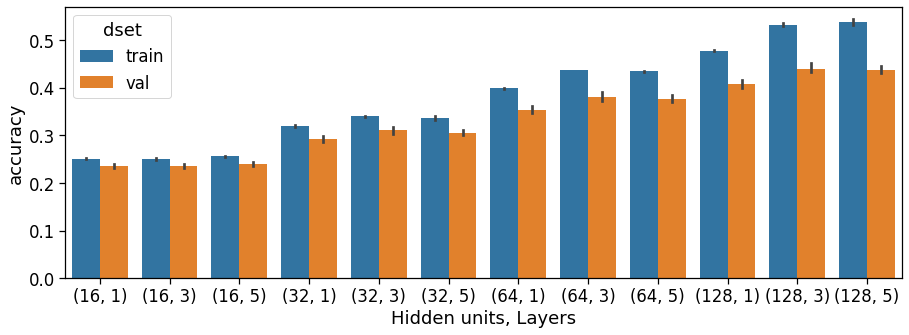

In [7]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='model',y='accuracy',data=df,hue='dset')
ax.set_xticklabels([(d['k_hidden'],d['k_layers']) for d in params])
ax.set_xlabel('Hidden units, Layers')
acc = df[df['dset']=='val'].groupby('model').mean().sort_values(by='accuracy',ascending=False).iloc[0,0]
opt_model = df[df['dset']=='val'].groupby('model').mean().sort_values(by='accuracy',ascending=False).head(1).index.item()
print('Best val accuray of: %.3f' %(acc))

In [6]:
df.groupby(['model','dset'])['accuracy'].agg([np.mean, np.std]).sort_values(by='mean',ascending=False)

,,mean,std
model,dset,,
model11,train,0.537602,0.007434
model10,train,0.532138,0.003788
model09,train,0.477759,0.002052
model10,val,0.440257,0.011724
model07,train,0.436924,0.000683
model11,val,0.436810,0.009331
model08,train,0.434115,0.002719
model09,val,0.406838,0.010792
model06,train,0.398945,0.001774


In [12]:
print('Best params:',params[7])

Best params: {'k_hidden': 32, 'k_layers': 2}


In [13]:
## Test
clip_y = _get_clip_labels()
k_class = len(np.unique(list(clip_y.values())))
print('number of classes = %d' %k_class)

clip_names = np.zeros(k_class).astype(str)
clip_names[0] = 'testretest'
for key, item in clip_y.items():
    if item!=0:
        clip_names[item] = key
        
res_path = 'results/clip_gru/'

number of classes = 15


In [14]:
with open('results/clip_ff/roi_300_net_7_trainsize_100_k_hidden_32_k_layers_2_batch_size_32_num_epochs_45_z_1.pkl',"rb") as  f:
    results, results_prob = pickle.load(f)

In [15]:
df = pd.DataFrame()
for dset in results_prob:
    for mov_i, movie in enumerate(clip_names):
        for t_prob in results_prob[dset]['t_prob'][mov_i]:
            tmp_df = pd.DataFrame(t_prob,columns=['probs'])
            tmp_df['acc'] = results_prob[dset]['acc']
            tmp_df['dset'] = dset
            tmp_df['movie'] =  movie
            tmp_df['time'] = np.arange(t_prob.shape[0])
            df = pd.concat([df,tmp_df],ignore_index=True)

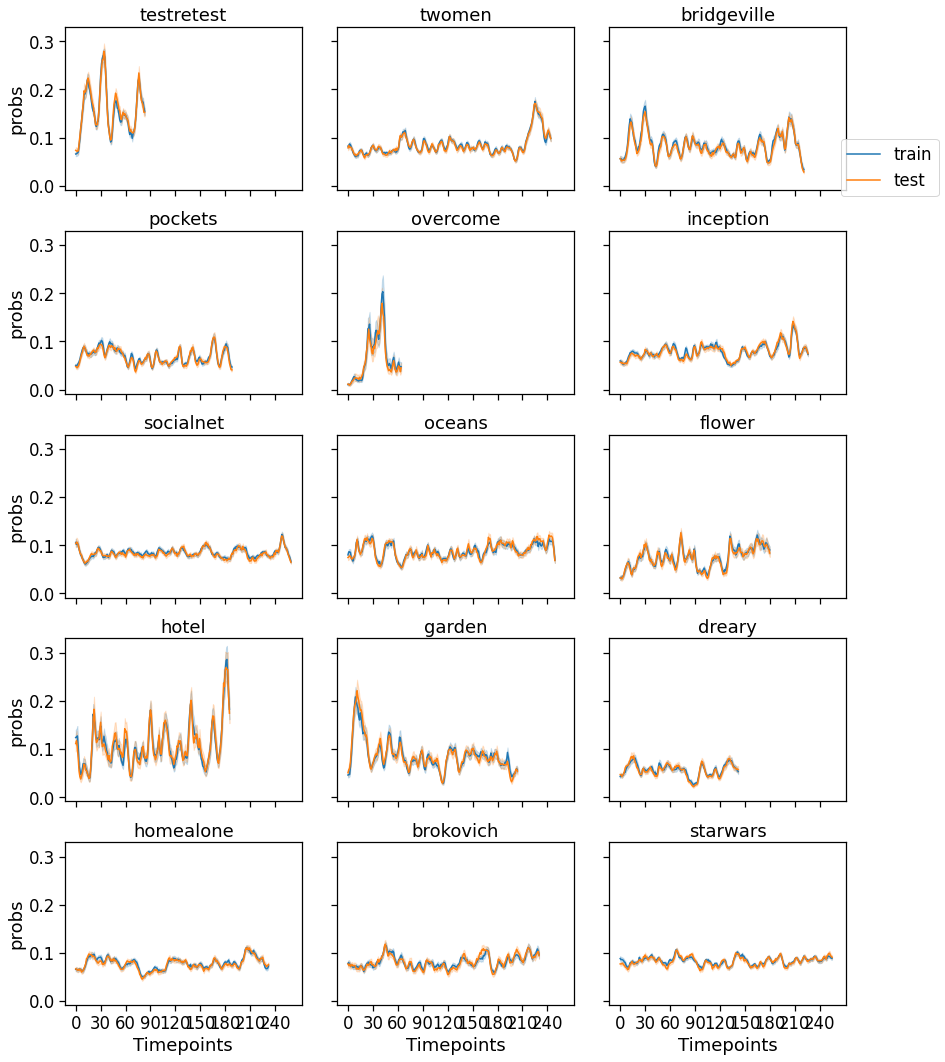

In [16]:
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=(14,18),sharey=True,sharex=True)
axes = axes.flatten()

fig.subplots_adjust(hspace=0.25,wspace=0.15)

for mov_i, movie in enumerate(clip_names):
    movie_df = df[df['movie']==movie]
    sns.lineplot(x='time',y='probs',hue='dset',data=movie_df,ax=axes[mov_i],legend=False)
    axes[mov_i].set_title(movie)
    axes[mov_i].set_xlabel('Timepoints')
    axes[mov_i].set_xticks(np.arange(0,260,30))
    
fig.legend(['train','test'],bbox_to_anchor=[1,0.8])

In [17]:
train = pd.Series(results['train'],name='acc',index=np.arange(100)).to_frame()
test = pd.Series(results['test'],name='acc',index=np.arange(100,176)).to_frame()
result_table = pd.concat([train,test],axis=0)

result_table['dset'] = 'train'
result_table.loc[100:,'dset'] = 'test'

Mean train accuracy: 0.17
Mean test accuracy: 0.17


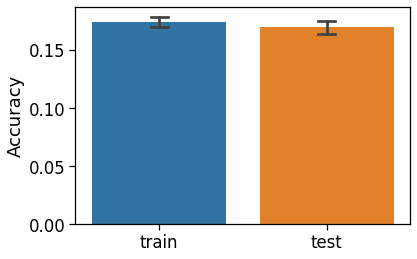

In [18]:
#plt.figure(figsize=(8,6))
sns.barplot(x='dset',y='acc',data=result_table,capsize=0.10)
plt.xlabel('')
_=plt.ylabel('Accuracy')
print('Mean train accuracy: %.2f'%train.mean().item())
print('Mean test accuracy: %.2f'%test.mean().item())